In [1]:
"""
Name: example_prob_model_atten_test.ipynb
Authors: Stephan Meighen-Berger
Example how to use the probabilistic model to get an estimate of the attenuation length
"""

'\nName: example_prob_model_atten_test.ipynb\nAuthors: Stephan Meighen-Berger\nExample how to use the probabilistic model to get an estimate of the attenuation length\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
import scipy.special as sps
from matplotlib.pyplot import cm
from scipy import optimize

In [3]:
# picture path
PICS = '../pics/'

In [4]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=1.
h_length=1.

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [6]:
number_of_files = list(range(1001))[1:]
number_of_peaks_base = []
peak_heights_base = []
peak_widths_base = []
res_dic_list = []
sets = [1, 2, 3]
factors_arr = [1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1,
               6e-1, 7e-1, 8e-1, 9e-1,
               9.5e-1, 9.9e-1, 1.01e0, 1.05e0,
               1.1e0, 1.2e0, 1.3e0, 1.4e0, 1.5e0,
               1.6e0, 1.7e0, 1.8e0, 1.9e0,
               2e0, 5e0, 1e1]
# The subsets
factors_arr_1 = [1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1,
                 6e-1, 7e-1, 8e-1, 9e-1]
factors_arr_2 = [9.5e-1, 9.9e-1, 1.01e0, 1.05e0,
                 1.1e0, 1.2e0, 1.3e0, 1.4e0, 1.5e0]
factors_arr_3 = [1.6e0, 1.7e0, 1.8e0, 1.9e0,
                 2e0, 5e0, 1e1]
# factors_arr = [1e-2, 1e-1, 5e-1, 7e-1, 9e-1,
#                1.1e0, 1.3e0, 1.5e0, 1.9e0, 1e1]
for number in number_of_files:
    for subset in sets:
        # Base is only in 1
        if subset == 1:
            try:
                res_dic = pickle.load(open("results_v4\\comp_v4_%d_sim_%d.p" %(subset, number), "rb"))
                if ((list(res_dic.keys()) != factors_arr_1) and
                    (list(res_dic.keys()) != factors_arr_2) and
                    (list(res_dic.keys()) != factors_arr_3)):
                    print(res_dic.keys())
                    continue
                res_dic_list.append(res_dic)
                base = pickle.load(open("results_v4\\base_v4_%d_sim_%d.p" %(subset, number), "rb"))
                number_of_peaks_base.append(base[0])
                peak_heights_base.append(base[1])
                peak_widths_base.append(base[2])
            except:
                continue
        else:
            try:
                res_dic = pickle.load(open("results_v4\\comp_v4_%d_sim_%d.p" %(subset, number), "rb"))
                if ((list(res_dic.keys()) != factors_arr_1) and
                    (list(res_dic.keys()) != factors_arr_2) and
                    (list(res_dic.keys()) != factors_arr_3)):
                    print(res_dic.keys())
                    continue
                res_dic_list.append(res_dic)
            except:
                continue
print("Successful simulation runs: %d" % len(res_dic_list))

Successful simulation runs: 3000


In [7]:
bins_heights = np.logspace(2., 6., 41)
bins_width = np.linspace(0., 30., 300)

In [8]:
n_peaks_base_mean = np.mean(number_of_peaks_base)
n_peaks_base_std = np.std(number_of_peaks_base)
heights_counts = []
widths_counts = []
for run in peak_heights_base:
    for peak_height in run:
        hist, bin_edges = np.histogram(peak_height, bins=bins_heights)
        heights_counts.append(hist)
for run in peak_widths_base:
    for peak_width in run:
        hist, bin_edges = np.histogram(peak_width, bins=bins_width)
        widths_counts.append(hist)
heights_counts_mean = np.sum(heights_counts, axis=0)
widths_counts_mean = np.sum(widths_counts, axis=0)

In [9]:
mean_vals_peaks = {}
mean_vals_heights = {}
mean_vals_widths = {}
for id_fac, factors in enumerate(factors_arr):
    heights = []
    widths = []
    for res_dic in res_dic_list:
        try:
            mean_vals_peaks[factors] = np.mean(res_dic[factors][0])
            for peak_height in res_dic[factors][1]:
                hist, bin_edges = np.histogram(peak_height, bins=bins_heights)
                heights.append(hist)
            for peak_width in res_dic[factors][2]:
                hist, bin_edges = np.histogram(peak_width, bins=bins_width)
                widths.append(hist)
        except:
            continue
    mean_vals_heights[factors] = np.sum(heights, axis=0)
    mean_vals_widths[factors] = np.sum(widths, axis=0)

In [10]:
# print(n_peaks_base_mean)
# for factors in factors_arr:
#     print(mean_vals_peaks[factors])

In [11]:
def pdf(x, mu, sigma):
    """pdf of mormal distribution"""
    return (np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)))
def pdf_gamma(x, shape, scale):
    """gamma distro function"""
    return x**(shape-1.)*(np.exp(-x/scale) / (sps.gamma(shape)*scale**shape))
def pdf_multi(x, *params):
    """pdf of mormal distribution"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 2):
        mu = params[i]
        sigma = params[i+1]
        y = y  + (np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))) / 2.
        return y
def gaussian(x, height, center, width):
    # return height * x**(center-1.)*(np.exp(-x/width) / (sps.gamma(center)*width**center))
    return height*np.exp(-(x - center)**2/(2*width**2))
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3):
    return (gaussian(x, h1, c1, w1) +
        gaussian(x, h2, c2, w2) +
        gaussian(x, h3, c3, w3))
def two_gaussians(x, h1, c1, w1, h2, c2, w2):
    return three_gaussians(x, h1, c1, w1, h2, c2, w2, 0,0,1)
errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2

In [12]:
# Need to play with these values
guess2 = [6000., 3.8, 0.1, 3000., 5., 0.1]
# guess3 = [4000., 3., 0.1, 3000., 3., 0.1, 2000., 4., 0.5]

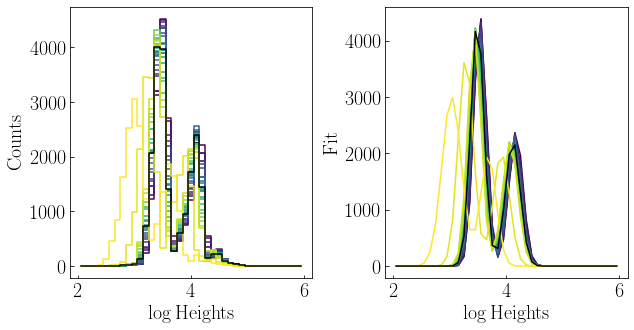

In [13]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(std_size, std_size * 4. / 8.), sharex=True)
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    ax1.step(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
             mean_vals_heights[factors], label=r'$%.1e$' %factors, color=c)
ax1.step(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
         heights_counts_mean, color='k', label=r'$True$')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\log\mathrm{Heights}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Counts}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# Norm fits
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
fit_vals_test = []
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    # popt, pcov = curve_fit(three_gaussians, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
    #                        mean_vals_heights[factors], p0=guess3)
    # yr = three_gaussians(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *popt)
    optim2, success = optimize.leastsq(errfunc2, guess2[:],
                                       args=(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                                             mean_vals_heights[factors]), ftol=1e-15, xtol=1e-15)
    fit_vals_test.append(optim2)
    # ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
    #          yr, color=c)
    ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
             two_gaussians(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *optim2),
             color=c)
optim2_base, success = optimize.leastsq(errfunc2, guess2[:],
                                        args=(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                                              heights_counts_mean))
# popt, pcov = curve_fit(pdf_multi, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
#                        normalized, p0=guess)
# yr = pdf_multi(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *popt)
# ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
#          yr, color='k')
ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
             two_gaussians(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *optim2_base),
             color='k')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\log\mathrm{Heights}$', fontsize=fontsize)
ax2.set_ylabel(r'$\mathrm{Fit}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(1., +1.4),
#                   ncol=5, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=False)
# ax1.set_ylim(1e0, 300)
# ax1.set_xlim(1e3, 1e6)
plt.subplots_adjust(wspace = 0.3, hspace = 0.)
figure.savefig(PICS + "Height_Distro_v4.png",
               bbox_inches='tight')
plt.show()

In [14]:
# To np arrays
fit_vals_test = np.array(fit_vals_test)

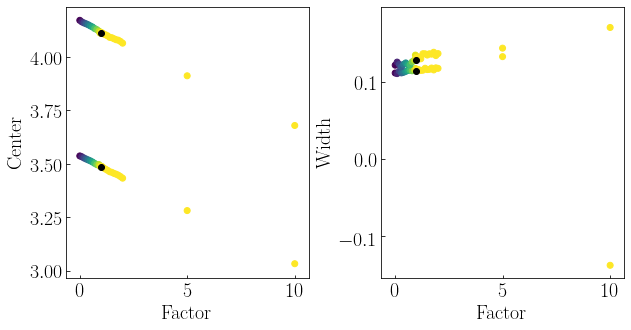

In [15]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(std_size, std_size * 4. / 8.), sharex=False)
# Norm fits
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
ax1.scatter(factors_arr,fit_vals_test[:, 1], c=cm.viridis(factors_arr))
ax1.scatter(factors_arr,fit_vals_test[:, 4], c=cm.viridis(factors_arr))
ax2.scatter(factors_arr,fit_vals_test[:, 2], c=cm.viridis(factors_arr))
ax2.scatter(factors_arr,fit_vals_test[:, 5], c=cm.viridis(factors_arr))
ax1.scatter(1., optim2_base[1], color='k')
ax1.scatter(1., optim2_base[4], color='k')
ax2.scatter(1., optim2_base[2], color='k')
ax2.scatter(1., optim2_base[5], color='k')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Center}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax2.set_ylabel(r'$\mathrm{Width}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
# h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(1., +1.4),
#                   ncol=5, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=False)
# ax1.set_ylim(3.5, 4.)
# ax1.set_xlim(0., 2.)
# ax2.set_ylim(0.55, 0.65)
# ax2.set_xlim(0., 2.)
plt.subplots_adjust(wspace = 0.3, hspace = 0.)
figure.savefig(PICS + "Para_Vals_v4.png",
               bbox_inches='tight')
plt.show()

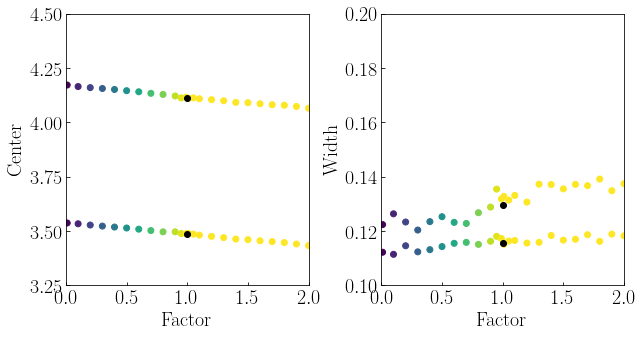

In [16]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(std_size, std_size * 4. / 8.), sharex=False)
# Norm fits
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
ax1.scatter(factors_arr,fit_vals_test[:, 1], c=cm.viridis(factors_arr))
ax1.scatter(factors_arr,fit_vals_test[:, 4], c=cm.viridis(factors_arr))
ax2.scatter(factors_arr,fit_vals_test[:, 2], c=cm.viridis(factors_arr))
ax2.scatter(factors_arr,fit_vals_test[:, 5], c=cm.viridis(factors_arr))
ax1.scatter(1., optim2_base[1], color='k')
ax1.scatter(1., optim2_base[4], color='k')
ax2.scatter(1., optim2_base[2], color='k')
ax2.scatter(1., optim2_base[5], color='k')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Center}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax2.set_ylabel(r'$\mathrm{Width}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
# h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(1., +1.4),
#                   ncol=5, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=False)
ax1.set_ylim(3.25, 4.5)
ax1.set_xlim(0., 2.)
ax2.set_ylim(0.1, 0.2)
ax2.set_xlim(0., 2.)
plt.subplots_adjust(wspace = 0.3, hspace = 0.)
figure.savefig(PICS + "Para_Vals_Zoom_v4.png",
               bbox_inches='tight')
plt.show()

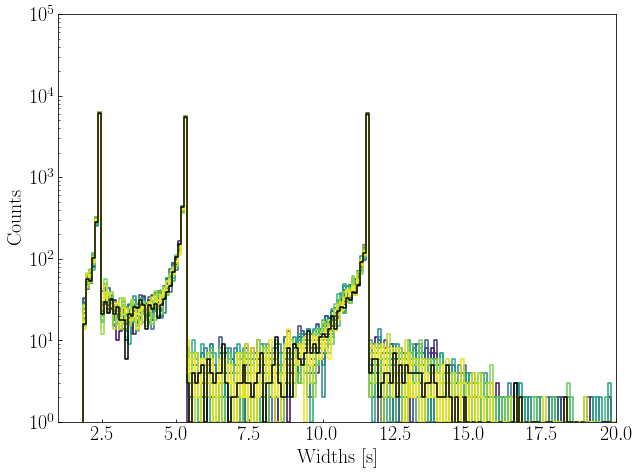

In [17]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    ax1.step((bins_width[1:] + bins_width[:-1])/2, mean_vals_widths[factors], color=c)
ax1.step((bins_width[1:] + bins_width[:-1])/2, widths_counts_mean,
         color='k')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{Widths}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Counts}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.0),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e0, 1e5)
ax1.set_xlim(1., 20)
figure.savefig(PICS + "Width_Distro_v4.png",
               bbox_inches='tight')
plt.show()